moving_average_predict:
              Date   Close    Open    High     Low   Volume  moving_average
1101  Jan 05, 2020  7372.5  7376.8  7501.0  7345.6  628.14K         8052.87
1102  Jan 04, 2020  7376.8  7345.1  7433.1  7291.4  523.91K         7907.63
1103  Jan 03, 2020  7343.1  6967.1  7402.9  6884.1  936.29K         7830.80
1104  Jan 02, 2020  6967.0  7199.7  7209.6  6901.4  632.78K         7708.74
1105  Jan 01, 2020  7199.8  7196.4  7259.4  7180.0  420.28K         7626.31
Predicted price for the next period: 7626.31
Mean Absolute Error (MAE) for the test data: 384.5654751131222
linear_regression_predict:
MSE: 350336524.2085689
R-squared: -0.2038501104862498
Model Coefficient: [-6.10503676]
Model intercept: 37832.69756615781
random_forest_predict:
MSE: 2294663.100748535
R-squared: 0.9921149231196909
Feature_importances: [1.]
n_estimators: 10 max_depth_options: [None, 10, 20, 30]
random_forest_predict_with_hyperparameters:
MSE: 2404933.0781411375
R-squared: 0.9917360059492152
Feature_

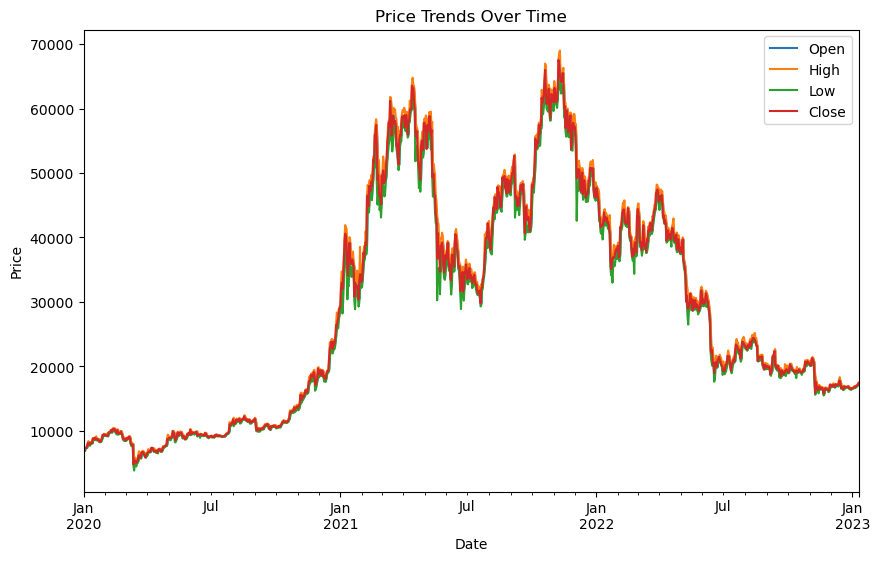

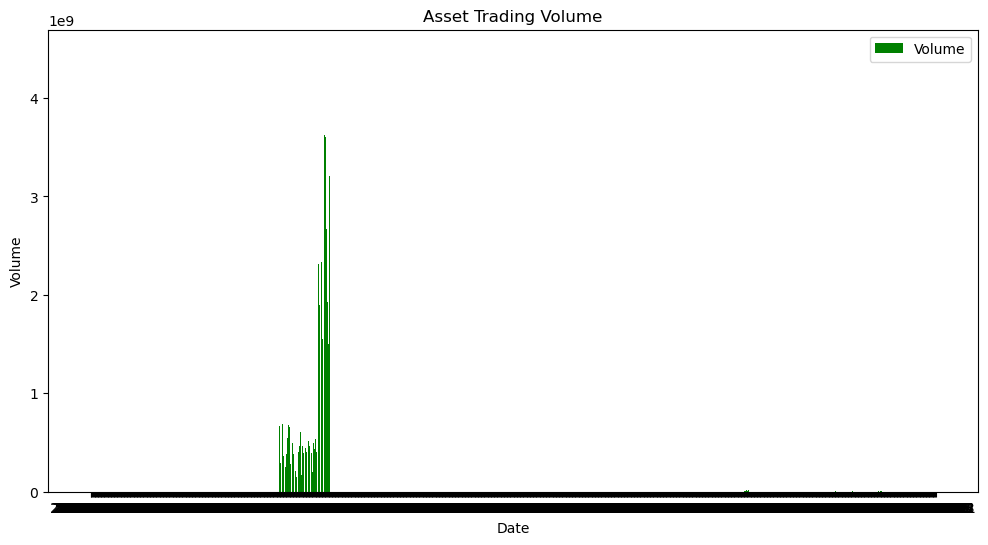

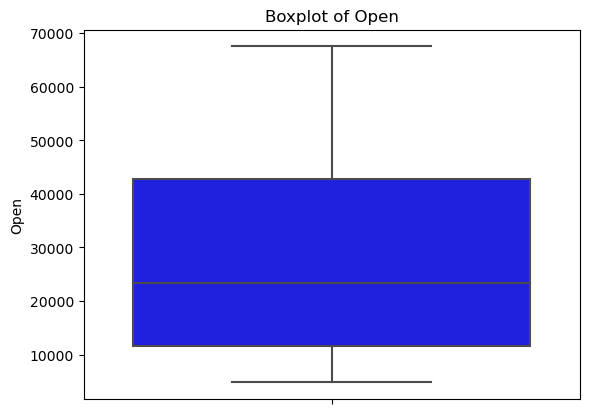

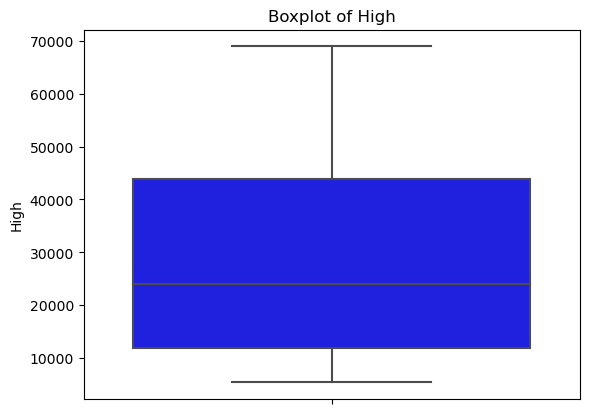

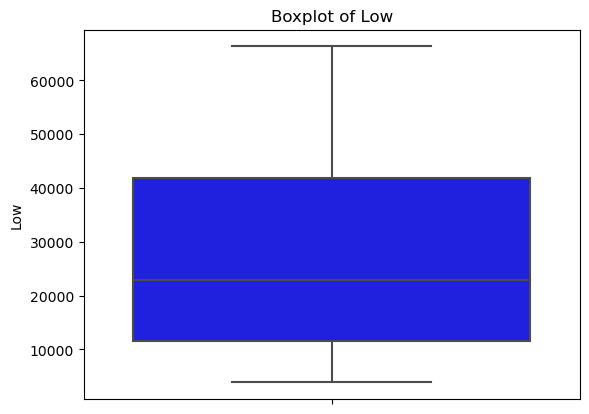

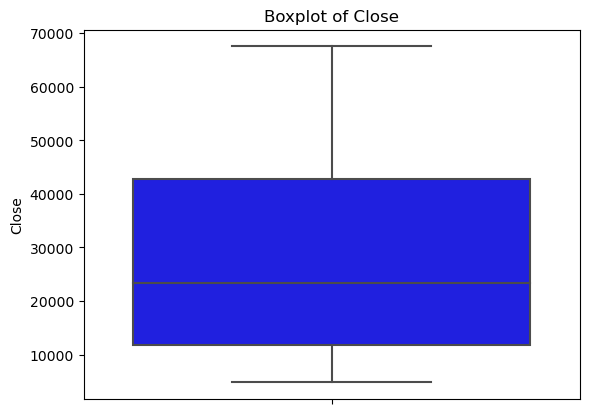

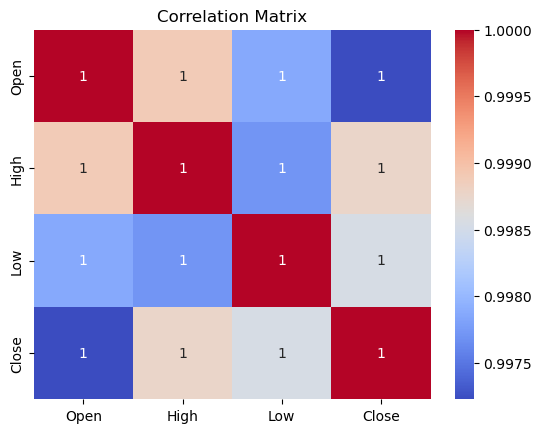

In [17]:
# -*- coding: utf-8 -*- 
# @Time : 2024/1/21 22:54 
# @Author : cyw
# @File : test2.py

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


def convert_volume(value):
    if 'K' in value:
        return float(value.replace('K', '')) * 1000
    elif 'M' in value:
        return float(value.replace('M', '')) * 1000000
    elif 'B' in value:
        return float(value.replace('B', '')) * 1000000000
    return float(value)


def convert_to_float(x):
    try:
        return float(x.replace(',', ''))
    except:
        return x


def plot_boxplot(df, column, color):
    sns.boxplot(data=df, y=column, color=color)
    plt.title(f'Boxplot of {column}')
    plt.show()


def description_function(df):
    for column in ['Open', 'High', 'Low', 'Close']:
        df[column] = df[column].apply(convert_to_float)

    # Display basic info about the dataset
    print("\nBasic information about the dataset:")
    print(df.info())

    
    print("First 5 rows of the dataset:")
    print(df.head())

    # Display the data types of each column
    print("\nData types of each column:")
    print(df.dtypes)

    # Display summary statistics
    print("\nSummary statistics:")
    print(df.describe())
    
    mean_sales = df['Close'].mean()
    std_sales = df['Close'].std()

    threshold = mean_sales + 3 * std_sales
    outliers = df[df['Close'] > threshold]

    print("Abnormal Value：")
    print(outliers)

    df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y')
    df['Formatted Date'] = df['Date'].dt.strftime('%Y-%m-%d')

    df['Volume'] = df['Volume'].apply(convert_volume)

    data_info = df.info()
    df.set_index('Date', inplace=True)
    df[['Open', 'High', 'Low', 'Close']].plot(figsize=(10, 6))
    plt.title('Price Trends Over Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.bar(df['Formatted Date'], df['Volume'], label='Volume', color='green')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.title('Asset Trading Volume')
    plt.legend()
    plt.show()

    for column in ['Open', 'High', 'Low', 'Close']:
        plot_boxplot(df, column, 'blue')

    corr_matrix = df[['Open', 'High', 'Low', 'Close']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()


def moving_average_predict(data, window_size):
    print(f"moving_average_predict:")

    # Calculate moving average
    data['moving_average'] = data['Close'].rolling(window=window_size).mean()
    # check
    print(data.tail())

    # Use moving averages for forecasting
    # A simple approach is to assume that future prices are equal to the most recent moving average
    last_ma_value = data['moving_average'].iloc[-1]
    predicted_price = last_ma_value

    # Print out the expected value
    print("Predicted price for the next period:", predicted_price)

    # test if the answer is accurate
    test_data = data.tail(int(len(data) * 0.2))
    mean_absolute_error = np.mean(np.abs(test_data['Close'] - test_data['moving_average']))

    print("Mean Absolute Error (MAE) for the test data:", mean_absolute_error)


def linear_regression_predict(data, N):
    if N <= 0 or N >= len(data):
        return "N should be between 0 and the length of data"

    # turn date into days
    data['Date1'] = pd.to_datetime(data['Date'])
    start_date = data['Date1'].min()
    data['Days'] = (data['Date1'] - start_date).dt.days

    X = data[['Days']]
    y = data['Close']

    # use N data for training
    X_train = X.iloc[:N, :]
    y_train = y.iloc[:N]

    # set the training model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # make the prediction
    y_pred = model.predict(X)

    # how good is the model?
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    print(f"linear_regression_predict:")
    print(f"MSE: {mse}")
    print(f"R-squared: {r2}")
    print(f"Model Coefficient: {model.coef_}")
    print(f"Model intercept: {model.intercept_}")


def random_forest_predict(data, N):
    if N <= 0 or N >= len(data):
        return "N should be between 0 and the length of data"

    # turn date into days
    data['Date1'] = pd.to_datetime(data['Date'])
    start_date = data['Date1'].min()
    data['Days'] = (data['Date1'] - start_date).dt.days

    X = data[['Days']]
    y = data['Close']

    # use N data for training
    X_train = X.iloc[:N, :]
    y_train = y.iloc[:N]

    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # make the prediction
    y_pred = model.predict(X)

    # how good is the model?
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    print(f"random_forest_predict:")
    print(f"MSE: {mse}")
    print(f"R-squared: {r2}")
    print(f"Feature_importances: {model.feature_importances_}")


def random_forest_predict_hyperparameters(data, N, n_estimators, max_depth):
    data['Date1'] = pd.to_datetime(data['Date'])
    start_date = data['Date1'].min()
    data['Days'] = (data['Date1'] - start_date).dt.days

    X = data[['Days']]
    y = data['Close']

    X_train = X.iloc[:N, :]
    y_train = y.iloc[:N]

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
    model.fit(X_train, y_train)

    y_pred = model.predict(X)

    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    print(f"random_forest_predict_with_hyperparameters:")
    print(f"MSE: {mse}")
    print(f"R-squared: {r2}")
    print(f"Feature_importances: {model.feature_importances_}")
    

data = pd.read_csv('pv.csv')
for column in ['Open', 'High', 'Low', 'Close']:
    data[column] = data[column].apply(convert_to_float)
# copy for description
data_copy = data


N = 885  # 1107*0.8 = 885
# 3 ways:
moving_average_predict(data, 10)
linear_regression_predict(data, 885)
random_forest_predict(data, 885)

# maybe try them again with hyperparameters:
n_estimators_options = [10, 50, 100, 200]
max_depth_options = [None, 10, 20, 30]

for n_estimators in n_estimators_options:
    for max_depth in max_depth_options:
        print(f"n_estimators:", n_estimators, "max_depth_options:", max_depth_options)
        random_forest_predict_hyperparameters(data, N, n_estimators, max_depth)

for n_estimators in n_estimators_options:
    print(f"n_estimators:", n_estimators)
    moving_average_predict(data, n_estimators)

# summarize the data
description_function(data_copy)